## Similar Artists

In a similar 

Beginning with the basic setup and imports:

In [1]:
import pandas as pd
import numpy as np
import pickle

import sys, os
tim_path = 'C:\\Users\\Tim\\PycharmProjects\\625.687\src'
ben_path = '/Users/ben/Documents/625.687/src'

if os.path.exists(tim_path):
    sys.path.append(tim_path) # your local repo here
elif os.path.exists(ben_path):
    sys.path.append(ben_path)
else:
    print("Problem accessing src directory.")

try:
    path = "C:\\Users\\Tim\\Desktop\\MillionSongSubsetMillionSongSubset_dataframe.pkl" # your local data here
    df = pickle.load(open(path, "rb"))
except:
    path = ben_path + "/MillionSongSubset_dataframe.artist_name_similar_artists.pkl"
    df = pickle.load(open(path, "rb"))
#for c in sorted(df.columns):
#    print(c)

Now, some data cleaning:

In [15]:
import msd_utils

# Set up dataframe
subdf = df.drop_duplicates(subset='artist_name')
subdf = subdf.dropna()
subdf = subdf.head(300)

# Change similar artist list to set for quicker handling.
df['similar_artists'] = df.apply(lambda row: set(row['similar_artists']), axis=1)

print(len(subdf))

300


Finally, building the distance matrix using our metric `similar_artist_jaccard`, stored in `Metrics.py`.

In [16]:
import Metrics

mf = Metrics.Metric() # metric factory
metrics_df = []

# Compute a square matrix of scores (every song against every song)
for index1, row1 in subdf.iterrows():
    metric_scores = []
    #print(f"{len(metrics_df)}")
    for index2, row2 in subdf.iterrows():
        #try:
        score = mf.similar_artists_jaccard(row1, row2)
        metric_scores.append(score)
        #except:
        #    print(row1)
        #    print(row2)
    metrics_df.append(metric_scores)

dmatrix = np.array(metrics_df)

Now that we have our distance metric, we can compute the persistence diagram for $H_0$ and $H_1$. The computation for $H_2$ is, unfortunately, prohibitively expensive for the entire dataset.

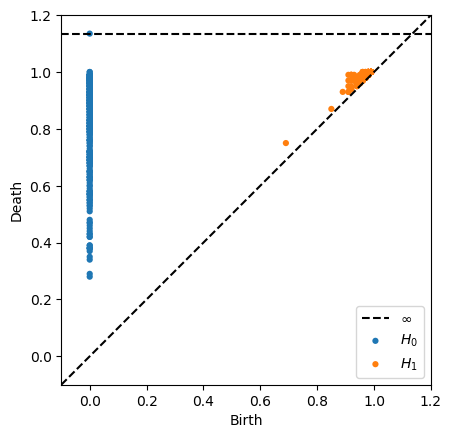

In [17]:
from ripser import ripser
from persim import plot_diagrams, persistent_entropy

res = ripser(dmatrix, distance_matrix=True)
plot_diagrams(res['dgms'], show=True)

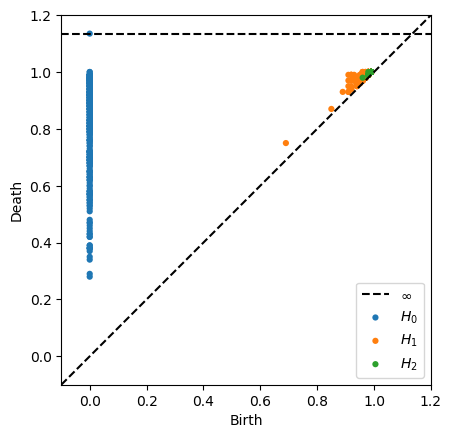

In [19]:
res = ripser(dmatrix, distance_matrix=True, maxdim=2)
plot_diagrams(res['dgms'], show=True)

In [6]:
persistent_entropy.persistent_entropy(res['dgms'])

array([4.57918665, 3.33793507, 1.38629436])

There is an interesting shape to the cluser in $H_1$, in the window where distance is between around .9 and 1.

In order to attempt to find some sort of structure in $H_2$, we'll try it with an abbreviated distance matrix.

In [7]:
#res_sub = ripser(dmatrix_sub, distance_matrix=True, maxdim=2)

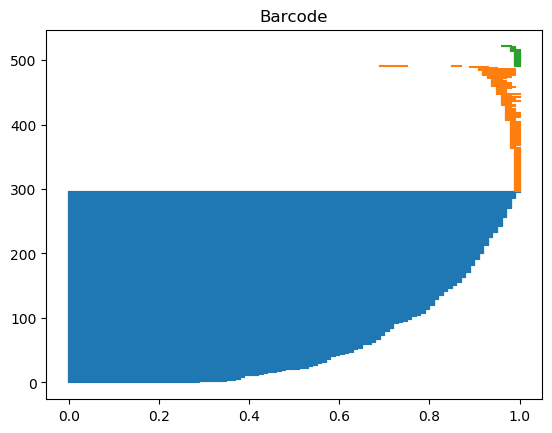

In [20]:
import matplotlib.pyplot as plt

def barcode(dgms, show=True):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    baseline = 0
    for d, homology in enumerate(dgms):
        for e, ele in enumerate(homology):
            plt.plot([ele[0], ele[1]], [baseline+e, baseline+e],
                    color=colors[d])
        baseline += e
    if show:
        plt.title("Barcode")
        plt.show()

barcode(res['dgms'])

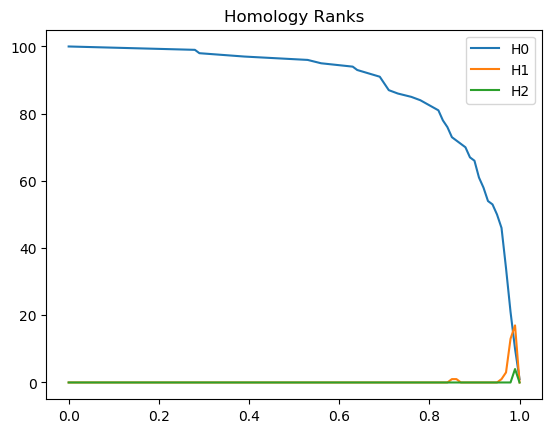

[100, 99, 98, 95, 97, 96, 94, 93, 91, 89, 87, 86, 85, 84, 81, 78, 61, 58, 54, 53, 70, 67, 66, 76, 8, -3, 1, 50, 45, 31, 71, 71, 72, 0]


In [9]:
def homology_ranks(dgms, show=True):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    baseline = 0
    agg = {0:{}}
    # For each homology in the array from Ripser
    for dim, homology in enumerate(dgms):
        # Collect all of the distances for births...
        dists = {span[0] for span in homology}
        # ...and deaths...
        dists = dists.union({span[1] for span in homology if span[1] != 'inf'})
        # Sort the distances and add to the aggregate dictionary.
        for d in dists:
            agg[d] = {}
    
    for dim, homology in enumerate(dgms):
        # Count the number of elements alive at distance d
        count = []
        for dist in sorted(agg):
            cnt = len([h for h in homology if h[0] <= dist and dist < h[1]])
            agg[dist][dim] = cnt
        # Add the counts to the plot.
        plt.plot(sorted([d for d in agg]), [agg[d][dim] for d in sorted(agg)],
                color=colors[dim], label=f"H{dim}")
    if show:
        plt.legend()
        plt.title("Homology Ranks")
        plt.show()

    # Various other computations:
    for dist in agg:
        e_ch = sum([((-1)**dim)*agg[dist][dim] for dim, _ in enumerate(dgms)])
        agg[dist]['euler_char'] = e_ch

    return agg
    

agg = homology_ranks(res['dgms'])
print([agg[d]['euler_char'] for d in agg])

There still appears to be not much structure here...

Using another submodule called KeplerMapper, we'll take another look at the data to see if any clusters arise:

In [14]:
for a in df.sample()['similar_artists']:
    print(a)

{b'AROKMTF11F50C4EC9E', b'ARJRAVQ12454A2E6EE', b'ARFFEDN11F4C84312A', b'ARBKGBA1187B98E2C5', b'ARM7UY51187B993E17', b'ARORBFV1187B9A1FDE', b'ARVIQL81187FB4E62B', b'ARRHJNH122CC3B1C6C', b'ARDMGXA11F50C475C4', b'AREUGDK1187B991F92', b'ARLULCI12454A2E6EA', b'AR56AP81187B98E4A6', b'ARR96OZ1187B990E59', b'ARHYECP1187B9A3F7E', b'ARCO1G01187FB3D671', b'AR5JUO91187FB4E90B', b'ARJQVBE1187FB3D623', b'ARZSLJK1187FB55341', b'AROAZVA124549A3F3D', b'ARCJWRV12454A4D2AE', b'AR9KO7F1187FB41736', b'ARAQ3A11187B9B6A03', b'AROUOZZ1187B9ABE51', b'ARUP17W1187B98CAB9', b'ARALQNM124207826E4', b'AR8IZBK1187FB55EAA', b'ARTSRWO12454A520ED', b'ARCJZV61187B9B9F61', b'ARTCFW71187B9967A5', b'ARGZE0X1187FB430E5', b'ARC6J781187B98F02B', b'ARPCEWC11F4C83EEA7', b'ARVTCS91187FB44DF6', b'AR02IU11187FB513F2', b'ARMGQLA1187B9AEBF8', b'ARMTE671187B995072', b'ARKLMJK1241B9CE9DF', b'AR6T08X1187B994F1C', b'ARMDHTH12AF7DADDFE', b'ARYETZM11E2835DBD4', b'ARUXWKC123E267034A', b'ARCLCFS1187B9AE476', b'ARWHWMX11F50C48809', b'AR1LSGQ1

In [11]:
import kmapper as km

#subdf_array = np.array(subdf)

mapper = km.KeplerMapper(verbose=1)
projected_data = mapper.fit_transform(dmatrix, distance_matrix=True, projection=[0,1])
graph = mapper.map(projected_data)
mapper.visualize(graph, path_html="SimilarArtists_km_output.html",
                 title="Year, Latitude, Longitude")

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: True
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (100, 100)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler(copy=True, feature_range=(0, 1))

Mapping on data shaped (100, 2) using lens shaped (100, 2)

Creating 100 hypercubes.

Created 0 edges and 1 nodes in 0:00:00.004964.
Wrote visualization to: SimilarArtists_km_output.html


ity\nfunction toggle_pane(content, content_id, tag) {\n  var active = content.active ? false : true;\n\n  if (active) {\n    content_id.style("display", "block");\n    tag.node().textContent = "[-]";\n  } else {\n    content_id.style("display", "none");\n    tag.node().textContent = "[+]";\n  }\n\n  // TODO: This is probably not the best way to find the correct height.\n  var h = canvas_height - content.offsetTop - padding;\n  content_id.style("height", h + "px")\n\n  content.active = active;\n}\n\nd3.select("#tooltip_control").on("click", function(e) {\n  toggle_pane(tooltip_content,\n              d3.select("#tooltip_content"),\n              d3.select("#tooltip_tag"))\n\n});\n\nd3.select("#meta_control").on("click", function(e) {\n  toggle_pane(meta_content,\n              d3.select("#meta_content"),\n              d3.select("#meta_tag"))\n\n});\n\nd3.select("#help_control").on("click", function(e) {\n  toggle_pane(helptip_content,\n              d3.select("#helptip_content"),\n    